In [1]:
# Install dependencies
!pip install --quiet kaggle
!pip install --quiet segmentation-models-pytorch --no-deps
!pip install --quiet albumentations
!pip install --quiet matplotlib scikit-learn
print("Libraries installed sucessfully !")

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 154.8/154.8 kB 11.9 MB/s eta 0:00:00
Libraries installed sucessfully !


In [2]:
from google.colab import files
import os

# Upload kaggle.json
print("Upload kaggle.json file:")
files.upload()

# Setup kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




Upload kaggle.json file:


Saving kaggle.json to kaggle.json


In [3]:
# Download dataset
# REPLACE with your actual dataset slug
dataset_slug = "omendrakumarupadhyay/crack-segmentation-datasetimage-mask"
!kaggle datasets download -d {dataset_slug}


Dataset URL: https://www.kaggle.com/datasets/omendrakumarupadhyay/crack-segmentation-datasetimage-mask
License(s): CC0-1.0


In [4]:
!unzip -q *.zip -d Crack_Dataset
print("Dataset downloaded and extracted.")

Dataset downloaded and extracted.


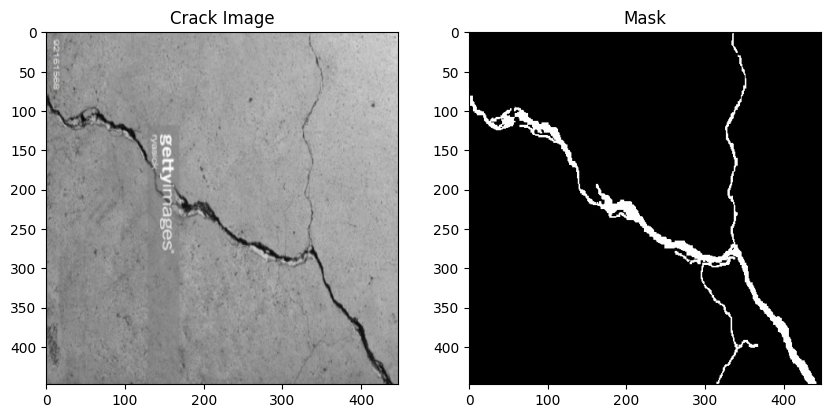

In [5]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import glob

image_paths = sorted(glob.glob('Crack_Dataset/Complete Dataset/images/*.jpg'))
mask_paths = sorted(glob.glob('Crack_Dataset/Complete Dataset/masks/*.jpg'))

idx = random.randint(0, len(image_paths)-1)
image = Image.open(image_paths[idx])
mask = Image.open(mask_paths[idx])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Crack Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()


In [6]:
sizes = set()
for img_path, mask_path in zip(image_paths, mask_paths):
    img_size = Image.open(img_path).size
    mask_size = Image.open(mask_path).size
    sizes.add((img_size, mask_size))

print(f"Unique (Image, Mask) sizes found: {len(sizes)}")
print(sizes)


Unique (Image, Mask) sizes found: 1
{((448, 448), (448, 448))}


In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CrackDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [8]:
# 80% Train, 10% Val, 10% Test
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

train_loader = DataLoader(CrackDataset(train_imgs, train_masks, transform), batch_size=8, shuffle=True)
val_loader = DataLoader(CrackDataset(val_imgs, val_masks, transform), batch_size=8, shuffle=False)
test_loader = DataLoader(CrackDataset(test_imgs, test_masks, transform), batch_size=8, shuffle=False)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")


Train: 9038, Val: 1130, Test: 1130


In [9]:
import torch.nn as nn
import torch

# Dice Loss implementation
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1 - dice

# Combine BCE + Dice
bce_loss = nn.BCELoss()
dice_loss = DiceLoss()

def combined_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)


In [10]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.PSPNet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [11]:
from tqdm import tqdm
import os

epochs = 50
checkpoint_dir = "/content/drive/MyDrive/CS_PSPnet_checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)

train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_path = ""

print("üöÄ Starting training...\n")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_loss = 0

    print(f"\nüìò Epoch {epoch+1}/{epochs}")
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = torch.sigmoid(outputs)

        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"‚úÖ Training loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"üîç Validation loss: {avg_val_loss:.4f}")

    # Save checkpoint
    checkpoint_path = f"{checkpoint_dir}/pspnet_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"üíæ Model checkpoint saved at: {checkpoint_path}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"{checkpoint_dir}/PSPnet_best_model.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"üèÜ Best model updated at: {best_model_path}")


üöÄ Starting training...


üìò Epoch 1/50


‚úÖ Training loss: 1.6306
üîç Validation loss: 1.6260
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_1.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 2/50


‚úÖ Training loss: 1.6169
üîç Validation loss: 1.6080
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_2.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 3/50


‚úÖ Training loss: 1.6106
üîç Validation loss: 1.6068
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_3.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 4/50


‚úÖ Training loss: 1.6094
üîç Validation loss: 1.6058
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_4.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 5/50


‚úÖ Training loss: 1.6086
üîç Validation loss: 1.6056
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_5.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 6/50


‚úÖ Training loss: 1.6080
üîç Validation loss: 1.6049
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_6.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 7/50


‚úÖ Training loss: 1.6072
üîç Validation loss: 1.6049
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_7.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 8/50


‚úÖ Training loss: 1.6067
üîç Validation loss: 1.6048
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_8.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 9/50


‚úÖ Training loss: 1.6065
üîç Validation loss: 1.6042
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_9.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 10/50


‚úÖ Training loss: 1.6060
üîç Validation loss: 1.6038
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_10.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 11/50


‚úÖ Training loss: 1.6057
üîç Validation loss: 1.6041
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_11.pth

üìò Epoch 12/50


‚úÖ Training loss: 1.6053
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_12.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 13/50


‚úÖ Training loss: 1.6050
üîç Validation loss: 1.6038
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_13.pth

üìò Epoch 14/50


‚úÖ Training loss: 1.6048
üîç Validation loss: 1.6040
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_14.pth

üìò Epoch 15/50


‚úÖ Training loss: 1.6046
üîç Validation loss: 1.6035
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_15.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 16/50


‚úÖ Training loss: 1.6042
üîç Validation loss: 1.6037
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_16.pth

üìò Epoch 17/50


‚úÖ Training loss: 1.6041
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_17.pth

üìò Epoch 18/50


‚úÖ Training loss: 1.6039
üîç Validation loss: 1.6034
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_18.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 19/50


‚úÖ Training loss: 1.6037
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_19.pth

üìò Epoch 20/50


‚úÖ Training loss: 1.6035
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_20.pth

üìò Epoch 21/50


‚úÖ Training loss: 1.6033
üîç Validation loss: 1.6038
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_21.pth

üìò Epoch 22/50


‚úÖ Training loss: 1.6031
üîç Validation loss: 1.6037
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_22.pth

üìò Epoch 23/50


‚úÖ Training loss: 1.6031
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_23.pth

üìò Epoch 24/50


‚úÖ Training loss: 1.6029
üîç Validation loss: 1.6037
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_24.pth

üìò Epoch 25/50


‚úÖ Training loss: 1.6027
üîç Validation loss: 1.6035
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_25.pth

üìò Epoch 26/50


‚úÖ Training loss: 1.6026
üîç Validation loss: 1.6035
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_26.pth

üìò Epoch 27/50


‚úÖ Training loss: 1.6025
üîç Validation loss: 1.6037
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_27.pth

üìò Epoch 28/50


‚úÖ Training loss: 1.6024
üîç Validation loss: 1.6034
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_28.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 29/50


‚úÖ Training loss: 1.6023
üîç Validation loss: 1.6035
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_29.pth

üìò Epoch 30/50


‚úÖ Training loss: 1.6021
üîç Validation loss: 1.6032
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_30.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 31/50


‚úÖ Training loss: 1.6021
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_31.pth

üìò Epoch 32/50


‚úÖ Training loss: 1.6020
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_32.pth

üìò Epoch 33/50


‚úÖ Training loss: 1.6019
üîç Validation loss: 1.6037
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_33.pth

üìò Epoch 34/50


‚úÖ Training loss: 1.6018
üîç Validation loss: 1.6034
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_34.pth

üìò Epoch 35/50


‚úÖ Training loss: 1.6016
üîç Validation loss: 1.6034
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_35.pth

üìò Epoch 36/50


‚úÖ Training loss: 1.6016
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_36.pth

üìò Epoch 37/50


‚úÖ Training loss: 1.6015
üîç Validation loss: 1.6035
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_37.pth

üìò Epoch 38/50


‚úÖ Training loss: 1.6014
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_38.pth

üìò Epoch 39/50


‚úÖ Training loss: 1.6013
üîç Validation loss: 1.6034
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_39.pth

üìò Epoch 40/50


‚úÖ Training loss: 1.6013
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_40.pth

üìò Epoch 41/50


‚úÖ Training loss: 1.6011
üîç Validation loss: 1.6037
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_41.pth

üìò Epoch 42/50


‚úÖ Training loss: 1.6012
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_42.pth

üìò Epoch 43/50


‚úÖ Training loss: 1.6011
üîç Validation loss: 1.6034
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_43.pth

üìò Epoch 44/50


‚úÖ Training loss: 1.6009
üîç Validation loss: 1.6033
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_44.pth

üìò Epoch 45/50


‚úÖ Training loss: 1.6008
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_45.pth

üìò Epoch 46/50


‚úÖ Training loss: 1.6008
üîç Validation loss: 1.6037
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_46.pth

üìò Epoch 47/50


‚úÖ Training loss: 1.6007
üîç Validation loss: 1.6035
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_47.pth

üìò Epoch 48/50


‚úÖ Training loss: 1.6006
üîç Validation loss: 1.6035
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_48.pth

üìò Epoch 49/50


‚úÖ Training loss: 1.6007
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_49.pth

üìò Epoch 50/50


‚úÖ Training loss: 1.6006
üîç Validation loss: 1.6036
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_50.pth


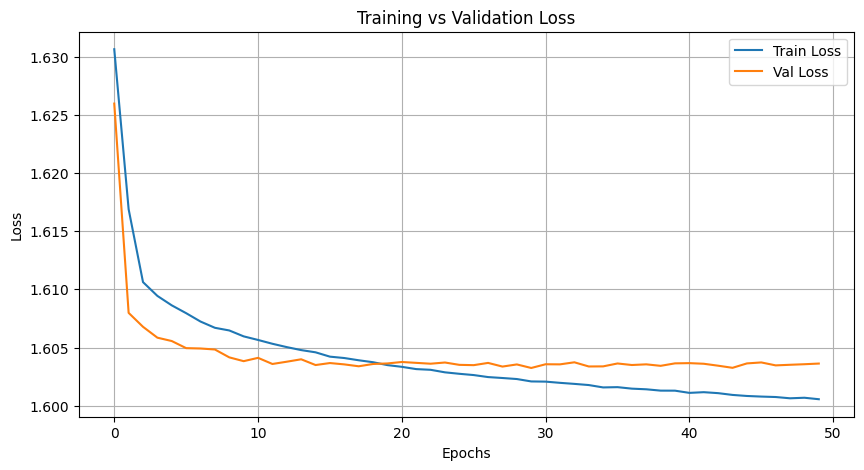

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


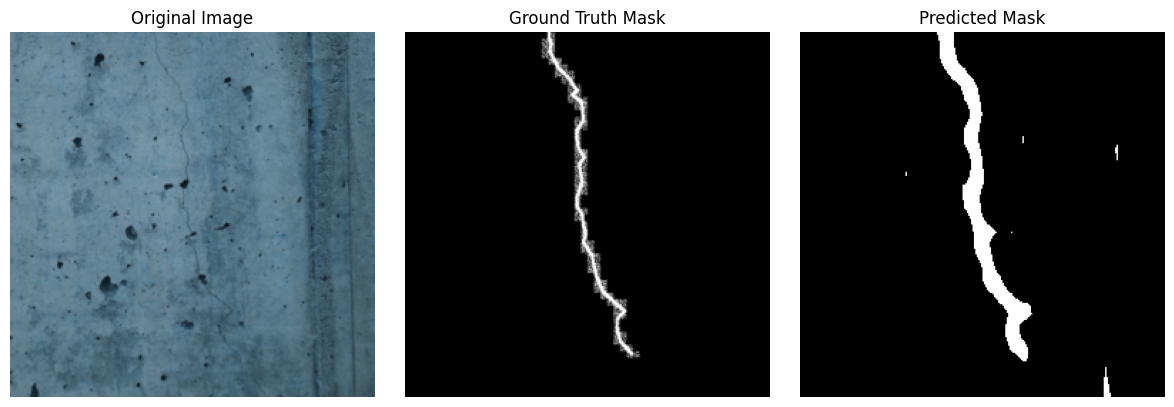

In [21]:
import matplotlib.pyplot as plt

# Load best model
best_model_path = "/content/drive/MyDrive/CS_PSPnet_checkpoints/PSPnet_best_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Get a batch from test_loader
images, masks = next(iter(test_loader))
image = images[0].to(device).unsqueeze(0)  # First image
gt_mask = masks[0]

# Predict
with torch.no_grad():
    output = model(image)
    output = torch.sigmoid(output)
    pred_mask = (output > 0.5).float()

# Convert tensors to numpy arrays for visualization
image_np = images[0].permute(1, 2, 0).cpu().numpy()
gt_mask_np = gt_mask.squeeze().cpu().numpy()
pred_mask_np = pred_mask.squeeze().cpu().numpy()

# Plot image, ground truth, and prediction
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_mask_np, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask_np, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


üîç Evaluating on test dataset...

‚úÖ Evaluation Metrics on Test Set:

Confusion Matrix:
 [[68648823  4226824]
 [   87217  1092816]]
IoU Score:       0.2021
Precision Score: 0.2054
Recall Score:    0.9261
F1 Score:        0.3363
Accuracy:        0.9417


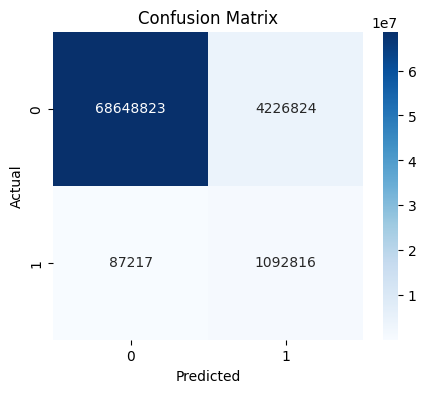

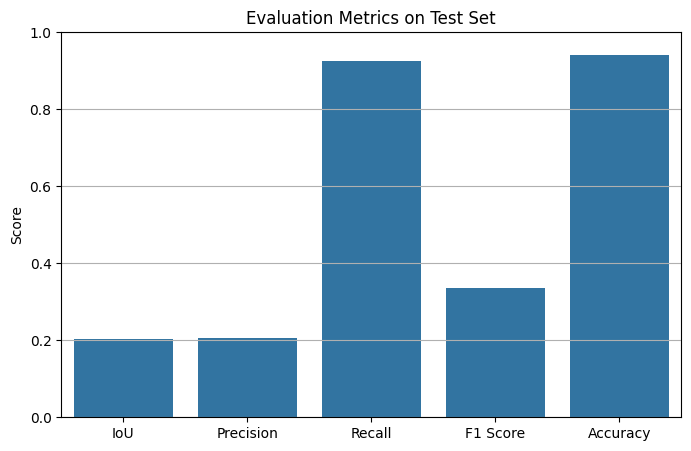

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score,
    f1_score, accuracy_score, jaccard_score
)

# Load the best model checkpoint
best_model_path = "/content/drive/MyDrive/CS_PSPnet_checkpoints/PSPnet_best_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_targets = []

print("üîç Evaluating on test dataset...\n")
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        outputs = torch.sigmoid(outputs)         # Apply sigmoid for binary mask
        preds = (outputs > 0.5).float()          # Threshold to get binary masks

        all_preds.append(preds.cpu().numpy())
        all_targets.append(masks.cpu().numpy())

# Flatten all predictions and targets
y_pred = np.concatenate(all_preds).flatten().astype(int)
y_true = np.concatenate(all_targets).flatten().astype(int)

# =================== Metrics Calculation =================== #
conf_matrix = confusion_matrix(y_true, y_pred)
iou = jaccard_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# =================== Metric Output =================== #
print("‚úÖ Evaluation Metrics on Test Set:\n")
print("Confusion Matrix:\n", conf_matrix)
print(f"IoU Score:       {iou:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score:    {recall:.4f}")
print(f"F1 Score:        {f1:.4f}")
print(f"Accuracy:        {accuracy:.4f}")

# =================== Plots =================== #
# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Bar Plot of All Scores
metrics = {
    "IoU": iou,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Accuracy": accuracy
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Evaluation Metrics on Test Set")
plt.grid(True, axis='y')
plt.show()


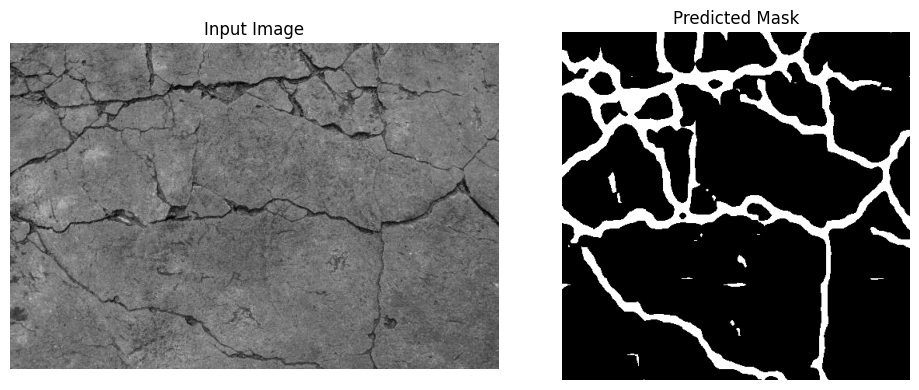

In [25]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the best model
best_model_path = "/content/drive/MyDrive/CS_PSPnet_checkpoints/PSPnet_best_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# ‚úÖ Image Preprocessing Function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),  # Converts to [0,1] and channels-first
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image, input_tensor

# ‚úÖ Predict Function
def predict_mask(image_path):
    orig_image, input_tensor = preprocess_image(image_path)

    with torch.no_grad():
        output = model(input_tensor)
        output = torch.sigmoid(output)              # Sigmoid for binary mask
        mask = (output > 0.5).float().squeeze().cpu().numpy()  # Threshold & remove batch/channel dims

    return orig_image, mask

# ‚úÖ Provide image path here
image_path = "/sample 3.jpg"  # üîÅ Change to your image path
input_image, predicted_mask = predict_mask(image_path)

# ‚úÖ Plot Input Image and Predicted Mask
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
